In [53]:
from dotenv import load_dotenv

load_dotenv()

True

In [54]:
import os

# update environment variable LANGCHAIN_PROJECT
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy-workshop"

In [55]:
# from langchain_ollama import ChatOllama

# llm = ChatOllama(model="llama3.2")

from langchain_groq import ChatGroq
llm = ChatGroq(model="llama-3.2-90b-vision-preview")


In [56]:
# State
from pydantic import BaseModel
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph import add_messages

def add_tendency(orig: list, new: list):
  print(f"tendencies {orig =} {new =}")
  return orig + new
  
class State(BaseModel):
  partner_name: str
  # input_messages: list[AnyMessage]
  messages: Annotated[list[AnyMessage], add_messages]
  summary: str = ""
  discussions: Annotated[list[AnyMessage], add_messages] = []
  discussion_summary: str = ""
  user_sentiment: str = "Sweet"
  user_tendencies: Annotated[list[str], add_tendency] = []
  

In [57]:
# Node
approvals = ['yes', 'y', 'sure', 'true']
# is_update_sentiment = input(f"Do you want to update the sentiment? last sentiment [ {state.user_sentiment} ] : ")

def get_sentiment(state):
  new_sentiment = input("what is the new sentiment? : ")
  return {
    'user_sentiment': new_sentiment
  }  
  
from langchain_core.messages import SystemMessage

def suggestion_llm(state):
  tendency_prompt = ', '.join(state.user_tendencies)
    
  system_prompt = f"""
  You are a assistant who will help Stephen sending reply messages. 
  You will be given the last message(s) that Stephen had with his partner({state.partner_name})
  Use the following provided context to devise the reply text messages: Stephen's intended sentiment, summary of previous conversations, Stephen's prepositions and summary of previous discussions Stephen had with you on this reply.
  
  If any of them are left in blank, don't worry about it. It just means that it hasn't been established yet. They will be filled in as the conversation carries on.
  
  latest messages between Stephen and {state.partner_name}: {state.messages}
  
  summary of previous conversation: {state.summary}

  Stephen's intended sentiment for this reply: {state.user_sentiment}
  
  Stephen's tendencies: {tendency_prompt}
  
  With this information devise and suggest text message reply(s) to Stpehen.
  
  Show three suggestions in a numbered format.
    
  """
  sys_messages = [SystemMessage(content=system_prompt)]
  
  if state.discussion_summary:
    discussion_summary_prompt = f"""
    Summary of discussion on this reply earlier: {state.discussion_summary}
    """
    sys_messages.append(SystemMessage(content=discussion_summary_prompt))
  
  suggesting_message = llm.invoke(sys_messages + state.discussions)
  
  return {
    'discussions': suggesting_message
  }
  

In [58]:
# Edge
from typing import Literal

def suggestion_conditional(state) -> Literal['__end__', 'suggestion_llm']:
  print(f"message: {state.discussions[-1].content}")
  user_approval = input(f"do you approve?:")
  if user_approval in approvals:
    return '__end__'
  else:
    return 'suggestion_llm'
    

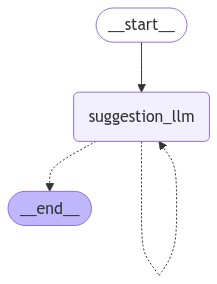

In [59]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver


builder = StateGraph(State)

# builder.add_node("get_sentiment", get_sentiment)
builder.add_node("suggestion_llm", suggestion_llm)

builder.add_edge(START, "suggestion_llm")
builder.add_conditional_edges("suggestion_llm", suggestion_conditional)

memory = MemorySaver()

graph = builder.compile(checkpointer=memory)

from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [52]:
config = {"configurable": {"thread_id": 1}}

from langchain_core.messages import HumanMessage

messages = [
  HumanMessage(content="Don't race with crazies", name="Stephen"),
  HumanMessage(content="I'm going to bed now", name="Stephen"),
  HumanMessage(content="Good night", name="Stephen"),
  HumanMessage(content="Bye\nNight", name="Deidra"),
  HumanMessage(content="I'm home", name="Deidra"),
  HumanMessage(content="I will drive crazy to you", name="Deidra"),
]

state = {
  'messages': messages,
  'partner_name': 'Deidra'
}

res = graph.invoke(state, config=config)

message: Based on the context provided, here are three reply message suggestions for Stephen to respond to Deidra with a sweet sentiment:

1. "Glad you made it home safely, love. Can't wait to see you tomorrow"
2. "Just got a little worried when I saw your message, but happy you're home safe. Sweet dreams, beautiful"
3. "Thank goodness you're home safe. I was a little scared when you said you'd drive crazy, but I know you can handle it. Love you, see you soon"

These suggestions aim to convey a sweet and caring tone, while also acknowledging Deidra's previous message and Stephen's relief that she made it home safely.
message: 
message: I've changed the suggestions to better fit the context:

1. "Glad you're home safe. Love you"
2. "Made it home in one piece, I hope? Love you"
3. "Home safe, that's all that matters. Love you, see you soon"

These suggestions aim to convey a sweet and caring tone, while also acknowledging Deidra's previous message about being home.


In [44]:
res

{'partner_name': 'Deidra',
 'messages': [HumanMessage(content="Don't race with crazies", additional_kwargs={}, response_metadata={}, name='Stephen', id='a4aabb03-e0c5-440c-aea9-0832550c4994'),
  HumanMessage(content="I'm going to bed now", additional_kwargs={}, response_metadata={}, name='Stephen', id='e0149909-6d3d-4737-9f81-a1dd523013fb'),
  HumanMessage(content='Good night', additional_kwargs={}, response_metadata={}, name='Stephen', id='c957565d-4669-40ae-988f-b4fa63fa8801'),
  HumanMessage(content='Bye\nNight', additional_kwargs={}, response_metadata={}, name='Deidra', id='fe495715-8d43-451a-985c-5bf81b33d202'),
  HumanMessage(content="I'm home", additional_kwargs={}, response_metadata={}, name='Deidra', id='c43b3e16-227a-40b4-ab31-28e474e72609'),
  HumanMessage(content='I will drive crazy to you', additional_kwargs={}, response_metadata={}, name='Deidra', id='748a8ada-f0f7-4fae-b6b7-16200be38fd7')],
 'discussions': [AIMessage(content='Based on the context provided, here are three